In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# data analysis
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rnd
from math import sqrt

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
%matplotlib inline
import plotly 
plotly.tools.set_credentials_file(username='catherinehata', api_key='JMatyB3EqCfeDb8NMZb8')
import plotly.graph_objs as go
import plotly.plotly as py
from xgboost import plot_importance

# time series
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from dateutil.relativedelta import relativedelta
import datetime

# machine learning
import xgboost as xgb
import operator
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.cross_validation import cross_val_score

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [44]:
# Some important functions (by Helge Bjorland & Stian Eide)
def plot_correlation_map(df):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = False, 
        annot_kws = { 'fontsize' : 12 },
        xticklabels=False, 
        yticklabels=False
    )
    plt.show()

# 1. CSV to Dataframe

In [45]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
train_set.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [46]:
train_set.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,30471.000000,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,1.686600e+04,20899.000000,20899.000000,16912.000000,...,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,3.047100e+04
mean,15237.917397,54.214269,34.403271,7.670803,12.558974,1.827121,3.068057e+03,1.909804,6.399301,2.107025,...,32.058318,10.783860,1.771783,15.045552,30.251518,0.442421,8.648814,52.796593,5.987070,7.123035e+06
std,8796.501536,38.031487,52.285733,5.319989,6.756550,1.481154,1.543878e+05,0.851805,28.265979,0.880148,...,73.465611,28.385679,5.418807,29.118668,47.347938,0.609269,20.580741,46.292660,4.889219,4.780111e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,7620.500000,38.000000,20.000000,3.000000,9.000000,1.000000,1.967000e+03,1.000000,1.000000,1.000000,...,2.000000,1.000000,0.000000,2.000000,9.000000,0.000000,0.000000,11.000000,1.000000,4.740002e+06
50%,15238.000000,49.000000,30.000000,6.500000,12.000000,1.000000,1.979000e+03,2.000000,6.000000,2.000000,...,8.000000,2.000000,0.000000,7.000000,16.000000,0.000000,2.000000,48.000000,5.000000,6.274411e+06
75%,22855.500000,63.000000,43.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,9.000000,3.000000,...,21.000000,5.000000,1.000000,12.000000,28.000000,1.000000,7.000000,76.000000,10.000000,8.300000e+06
max,30473.000000,5326.000000,7478.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,2014.000000,33.000000,...,377.000000,147.000000,30.000000,151.000000,250.000000,2.000000,106.000000,218.000000,21.000000,1.111111e+08


## 1.1 Dealing with missing values

In [47]:
# Number of observations
print('Total Number of Observations of train set: %d' %(train_set.shape[0]))
print('Total Number of Observations of test set: %d' %(test_set.shape[0]))
# Check the number of missing values for each column of train_set
# train_set.isnull().sum()
# Check the number of missing values for each column of test_set
test_set.isnull().sum()

Total Number of Observations of train set: 30471
Total Number of Observations of test set: 7662


id                                          0
timestamp                                   0
full_sq                                     0
life_sq                                  1176
floor                                       0
max_floor                                   0
material                                    0
build_year                               1049
num_room                                    0
kitch_sq                                    0
state                                     694
product_type                               33
sub_area                                    0
area_m                                      0
raion_popul                                 0
green_zone_part                             0
indust_part                                 0
children_preschool                          0
preschool_quota                          1596
preschool_education_centers_raion           0
children_school                             0
school_quota                      

## 1.2 Clean up/ process dataframe

In [48]:
# Clean up data and take care of NaN entries
# Drop all columns whose NaN entries take up more than 50 % of the samples.
no_rows_train = train_set.shape[0]
no_rows_test = test_set.shape[0]
train_set = train_set.dropna(axis = 1, thresh = int(0.5*no_rows_train))
test_set = test_set.dropna(axis = 1, thresh = int(0.5*no_rows_test))
# Fill NaN values with the mean or most frequent values
train_set = train_set.fillna(train_set.mean())
test_set = test_set.fillna(test_set.mean())
train_set = train_set.apply(lambda x:x.fillna(x.value_counts().index[0]))
test_set = test_set.apply(lambda x:x.fillna(x.value_counts().index[0]))

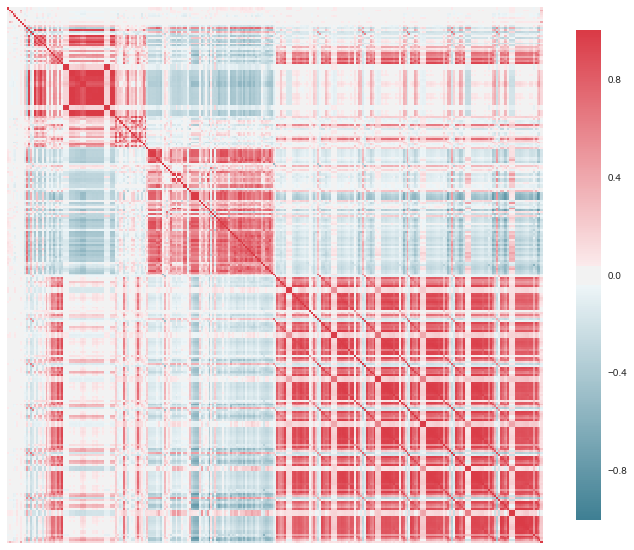

In [49]:
# Heatmap to see relationship/ correlation between predictors
# Note that we use original raw data for the following analysis
plot_correlation_map(train_set)

# Our features are plagued by multicollinearity. We need to take this into account when we perform regression

/Users/catherinehata/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning:

divide by zero encountered in log



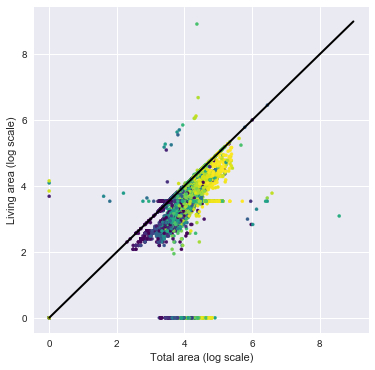

In [50]:
# Let's explore the relationship between full_sq and life_sq (total area and living area). The shading of the dots
# describes a change in sale prices. 
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.scatter(x = np.log(train_set['full_sq']).values, y = np.log(train_set['life_sq'].values), 
            c = preprocessing.LabelEncoder().fit_transform(train_set['price_doc']), s = 10, cmap = 'viridis')
plt.plot([0,9],[0,9],'k-', lw = 2)
plt.xlabel('Total area (log scale)')
plt.ylabel('Living area (log scale)')
plt.show()


There is a positive correlation between total area/ living area and sale price. Also, there are some outliers where the total area is less than living area or either of these entries has zero value. We will make some necessary changes to address this problem. 

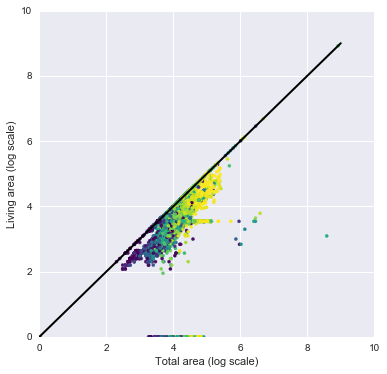

In [51]:
# Replace total area by living area if total area < living area:
train_set.loc[train_set['full_sq'].values < train_set['life_sq'].values,'full_sq'] \
    = train_set.loc[train_set['full_sq'].values < train_set['life_sq'].values,'life_sq']
# Replace total area by 1e-10 if there still exists a total area = 0:
train_set.loc[train_set['full_sq'].values == 0,'full_sq'] = 1e-10
# Replace living area by total area if living area = 0:
train_set.loc[train_set['life_sq'].values == 0,'life_sq'] \
    = train_set.loc[train_set['life_sq'].values == 0,'full_sq']
    

# Let's replot the previous scatter figure to make sure these details are corrected
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.scatter(x = np.log(train_set['full_sq']).values, y = np.log(train_set['life_sq'].values), 
            c = preprocessing.LabelEncoder().fit_transform(train_set['price_doc']), s = 10, cmap = 'viridis')
plt.plot([0,9],[0,9],'k-', lw = 2)
plt.xlabel('Total area (log scale)')
plt.ylabel('Living area (log scale)')
plt.xlim([0.0,10.0])
plt.ylim([0.0,10.0])
plt.show()

In [52]:
# Do the same corrections for test set
# Replace total area by living area if total area < living area:
test_set.loc[test_set['full_sq'].values < test_set['life_sq'].values,'full_sq'] \
    = test_set.loc[test_set['full_sq'].values < test_set['life_sq'].values,'life_sq']
# Replace total area by 1e-10 if there still exists a total area = 0:
test_set.loc[test_set['full_sq'].values == 0,'full_sq'] = 1e-10
# Replace living area by total area if living area = 0:
test_set.loc[test_set['life_sq'].values == 0,'life_sq'] \
    = test_set.loc[test_set['life_sq'].values == 0,'full_sq']

In [53]:
# Add a few features suggested by other people:
train_set['rel_floor'] = train_set['floor'] / train_set['max_floor'].astype(float) 
train_set.loc[train_set['max_floor'].values == 0, 'rel_floor'] = 0
train_set['rel_kitch_sq'] = train_set['kitch_sq'] / train_set['full_sq'].astype(float)


test_set['rel_floor'] = test_set['floor'] / test_set['max_floor'].astype(float) 
test_set.loc[test_set['max_floor'].values == 0, 'rel_floor'] = 0
test_set['rel_kitch_sq'] = test_set['kitch_sq'] / test_set['full_sq'].astype(float)

In [54]:
# Features only
X_train = train_set.drop(['id', 'price_doc'], axis = 1)
X_test = test_set.drop(['id'], axis = 1)
X_combined = pd.concat([X_train, X_test])
features = X_train.columns  
for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(X_combined[feature])
    X_train[feature] = le.transform(X_train[feature])
    X_test[feature] = le.transform(X_test[feature])
y_train = train_set['price_doc']

# Apply standard scaler to data
#scaler_tr = preprocessing.StandardScaler().fit(X_train)
#X_train = scaler_tr.transform(X_train)
#scaler_te = preprocessing.StandardScaler().fit(X_test)
#X_test = scaler_te.transform(X_test)

## 1.2 Exploring data

We investigate the distribution of the sale price. We first plot the distribution of the sale price for all of the recorded transactions.

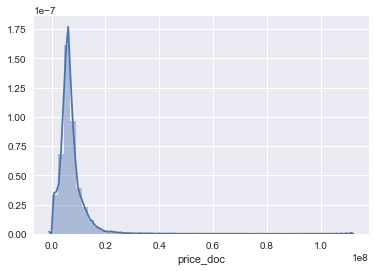

In [56]:
fig_sp = sns.distplot(y_train)

The distribution of the sale price is strongly right-skewed with a long tail

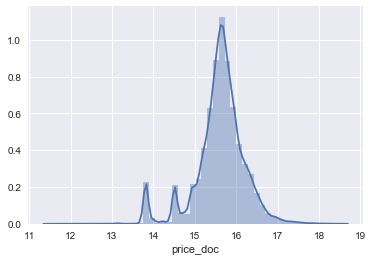

In [57]:
# Log transform the sale price to minimize the skew
y_train = np.log(y_train+1)
fig_sp_log = sns.distplot(y_train)

We then plot the kernel density estimation of the sale price for each year (with a log scale).  

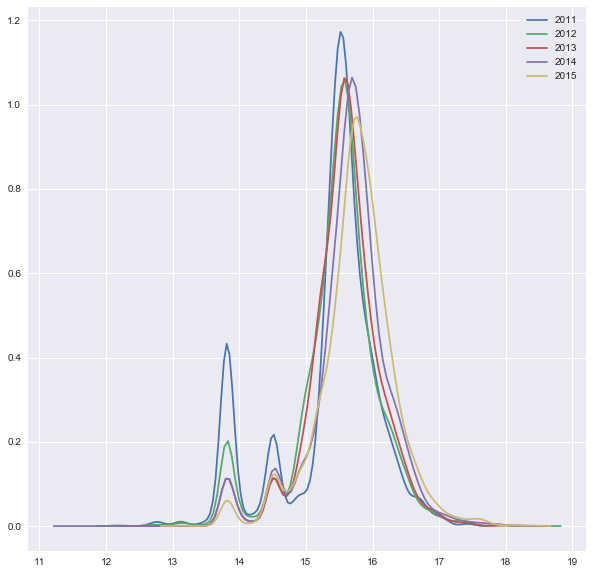

In [58]:
sale_df = train_set[['price_doc']]
Dates = pd.DatetimeIndex(train_set['timestamp'])
sale_df = sale_df.set_index(Dates)
sale_df.head()

price_2011 = sale_df['2011']
price_2012 = sale_df['2012']
price_2013 = sale_df['2013']
price_2014 = sale_df['2014']
price_2015 = sale_df['2015']

fig = plt.gcf()
fig.set_size_inches(10,10)
j = 1
for a in [price_2011, price_2012, price_2013, price_2014, price_2015]:
    sns.kdeplot(np.log(a['price_doc'].values), shade = False, bw = 0.1, label = "201" + str(j))
    j += 1

From the kernel density plot, we observe that the probability of the sale price of a house being in a higher range of values increases over the years. 

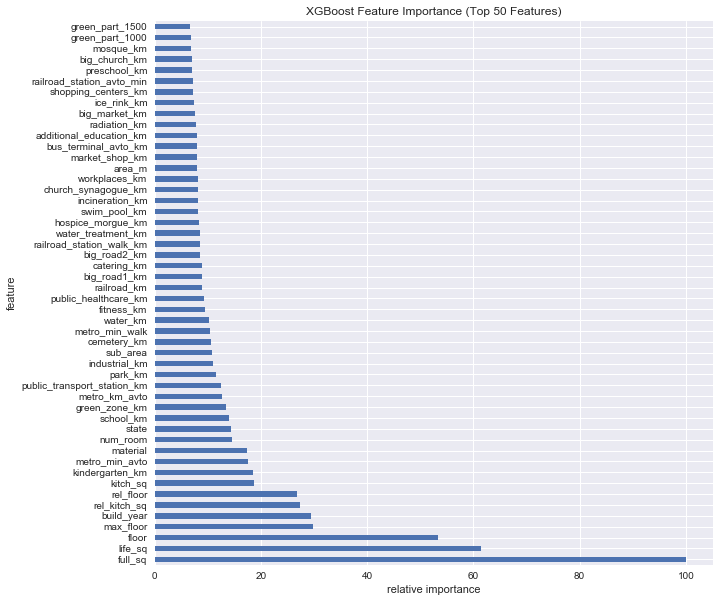

In [63]:
'''
feat_labels = X_train.columns[1:]

forest = ExtraTreesRegressor(n_estimators = 300,
                             max_features = 0.33,
                             random_state = 0,
                             n_jobs = -1,
                             bootstrap = True,
                             oob_score = True)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Feature Importances')
plt.barh(range(0,50), importances[indices[0:50]], color = 'blue', align = 'center')
plt.yticks(range(0,50), feat_labels)


'''

temp_train = X_train.drop(['timestamp'], axis = 1)
xgb_params = {"objective": "reg:linear", 
              "eta": 0.01, 
              "max_depth": 10, 
              "subsample": 0.5, 
              "colsample_bytree": 0.5,
              "silent": 1}
num_rounds = 1000

dtrain = xgb.DMatrix(temp_train, label=y_train, feature_names=temp_train.columns.values)
model = xgb.train(xgb_params, dtrain, num_rounds)

importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = 100*df['fscore'] / df['fscore'].max()
df=df.sort_values(by="fscore",ascending=False)

plt.figure()
df.head(50).plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 10))
plt.title('XGBoost Feature Importance (Top 50 Features)')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')


Then, we look at the relationship between sale price and the top 3 important features: full_sq (total area), life_sq (living area), floor of the building (floor) using a scatter plot. Note that we use original raw data for the following analysis

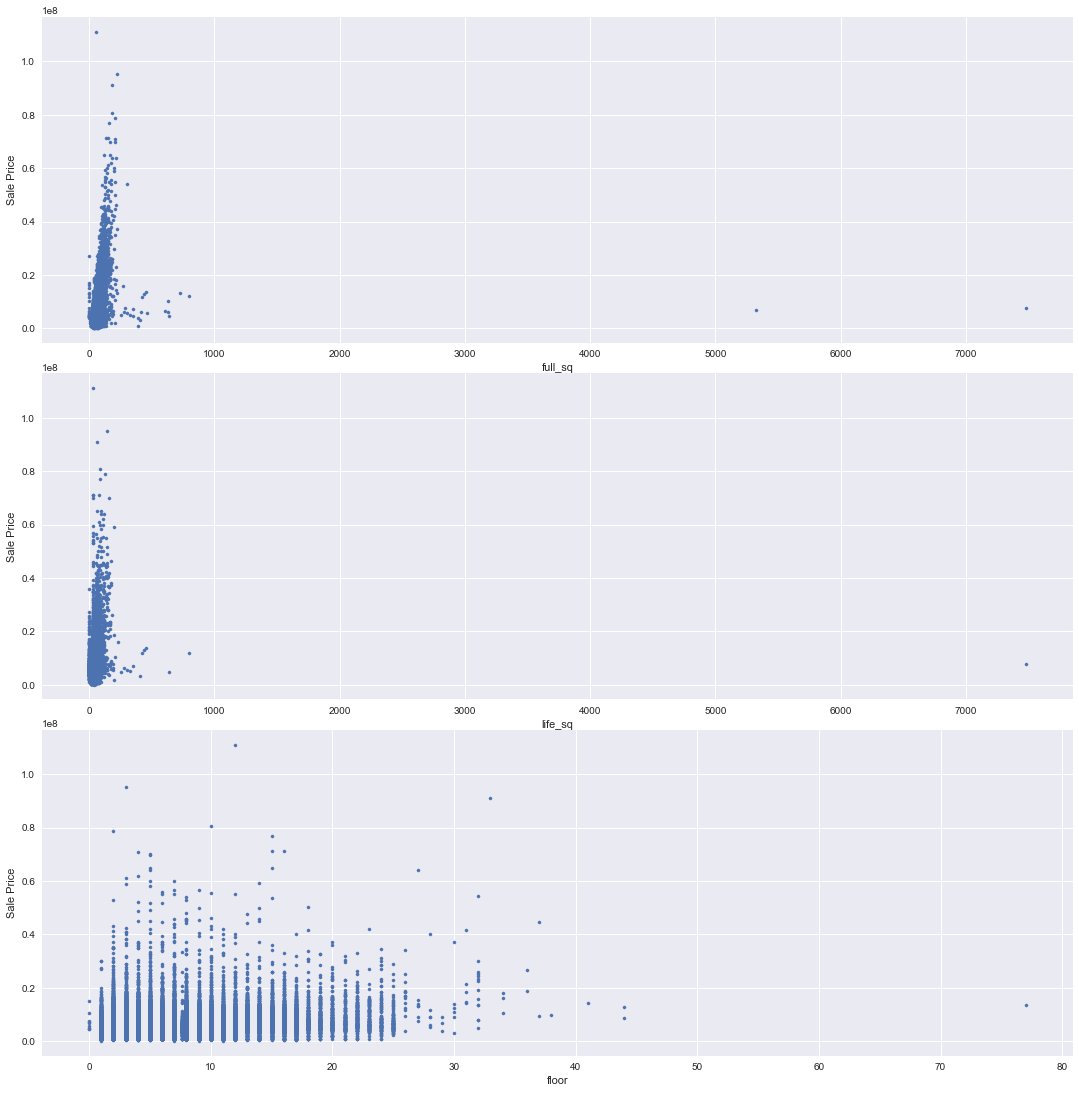

In [55]:
# We look at the relationship between sale price and the top 3 important features: full_sq (total area), 
# life_sq (living area), floor of the building (floor) using a scatter plot
# Note that we use original raw data for the following analysis

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (15,15))
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
c_j = 0
for j in ['full_sq', 'life_sq', 'floor']:
    ax[c_j].scatter(x = train_set[j].values, y = train_set['price_doc'], s = 10)
    #sns.kdeplot(train_set[j].values, train_set['price_doc'].values \
            #, ax = ax[c_j], n_levels=10, cmap = "Purples", shade = True)
    ax[c_j].set_xlabel(j)
    ax[c_j].set_ylabel("Sale Price")
    c_j += 1
plt.show()



# 2. Time series of average sale price by month

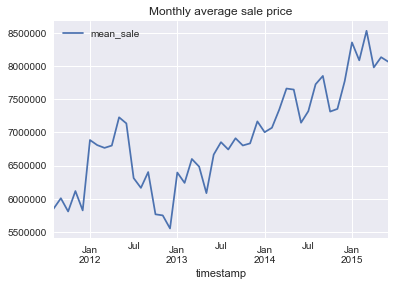

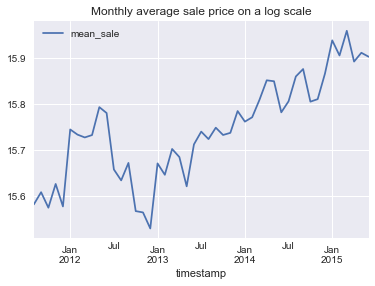

In [18]:
ts = train_set[['timestamp','price_doc']]
ts_train = ts # Create a new series with the sale price of the train set for latter usage
#Dates = pd.DatetimeIndex(train_set['timestamp'])
ts = ts.set_index(Dates).groupby(pd.TimeGrouper("M"))['price_doc'].agg({'mean_sale': np.mean})
ts = ts.dropna()
ts_log = np.log(ts)
ts.plot()
plt.title('Monthly average sale price')
plt.show()
ts_log.plot()
plt.title('Monthly average sale price on a log scale')
plt.show()

We apply first-order differencing to our time series to improve stationarity

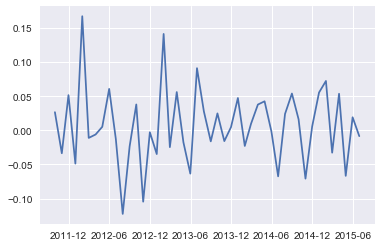

In [19]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
plt.plot(ts_log_diff)
plt.show()


The new series ts_log_diff looks stationarity. We apply ADF test to make sure that it is

In [20]:
# We check if residuals are stationary
result = adfuller(ts_log_diff.values.flatten())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.587707
p-value: 0.000000
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602


ADF Statistics confirms the stationarity of ts_log_diff. Now we can apply ARIMA modeling to this series. First we check the ACF and PACF plot

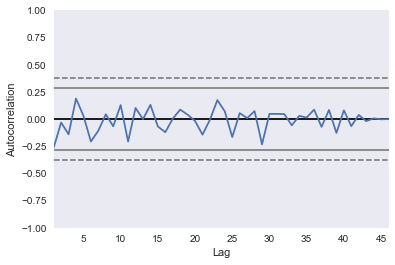

In [21]:
# A plot of the autocorrelation function
autocorrelation_plot(ts_log_diff)
plt.show()

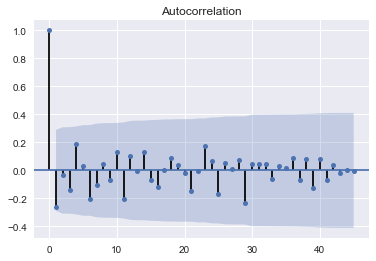

In [22]:
# A plot of the partial correlation function
plot_acf(ts_log_diff)
plt.show()

From the ACF plot and PACF plot, we most likely have an AR term of order 1. We now apply ARIMA(1,1,0) to forecast the average sale of houses per month

                             ARIMA Model Results                              
Dep. Variable:            D.mean_sale   No. Observations:                   45
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  54.605
Method:                       css-mle   S.D. of innovations              0.072
Date:                Tue, 09 May 2017   AIC                           -103.210
Time:                        13:58:21   BIC                            -97.790
Sample:                    10-31-2011   HQIC                          -101.190
                         - 06-30-2015                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -6.246e-05      0.007     -0.009      0.993      -0.013       0.013
ar.L1.D.mean_sale    -0.5823      0.118     -4.919      0.000      -0.814      -0.350
                        

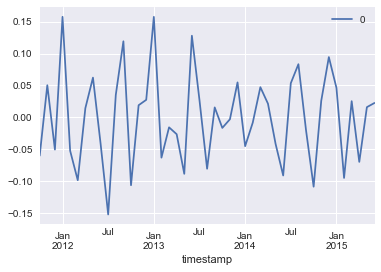

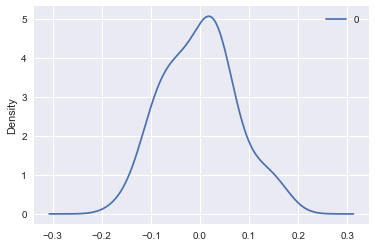

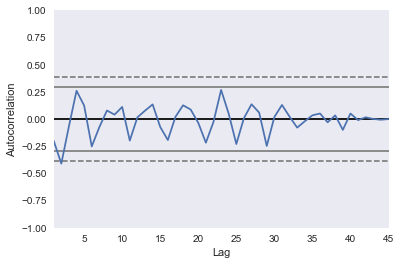

               0
count  45.000000
mean   -0.000778
std     0.072574
min    -0.152446
25%    -0.052460
50%     0.014311
75%     0.046093
max     0.157628


In [23]:
from statsmodels.tsa.arima_model import ARIMA
# fit model
model = ARIMA(ts_log_diff, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
autocorrelation_plot(residuals)
plt.show()
print(residuals.describe())

The residuals are normally distributed with mean 0. For the most part, the residuals are not strongly correlated, except for a spike at the beginning. This suggests that the Arima model captures the data quite well. 

Now, we quantify the performance of our model by witholding 1/3 of our data to be used as test data. We fit our model on the remaining 2/3 of the data. Then we look at the MSE value to examine the accuracy of our model. 

predicted=15.776371, expected=15.808950
predicted=15.807090, expected=15.851451
predicted=15.850067, expected=15.849394
predicted=15.860222, expected=15.781895
predicted=15.807869, expected=15.805879
predicted=15.807289, expected=15.859777
predicted=15.855054, expected=15.875920
predicted=15.881621, expected=15.805068
predicted=15.831012, expected=15.810536
predicted=15.816365, expected=15.865898
predicted=15.860777, expected=15.938200
predicted=15.932756, expected=15.905366
predicted=15.922450, expected=15.958951
predicted=15.956636, expected=15.892144
predicted=15.918761, expected=15.911237
predicted=15.915352, expected=15.902675
Test RMSE: 0.046


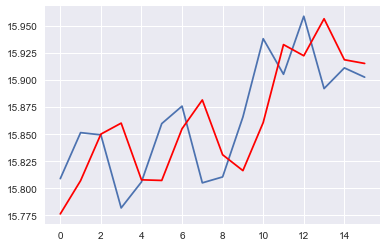

In [24]:
X = ts_log.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()


The test MSE is pretty low, suggesting that our model performs well on unseen data. Now, we apply our model to make predictions of average sale price for the next 12 months. 

In [25]:
start = datetime.datetime.strptime("2015-07-31", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= ts_log.columns)


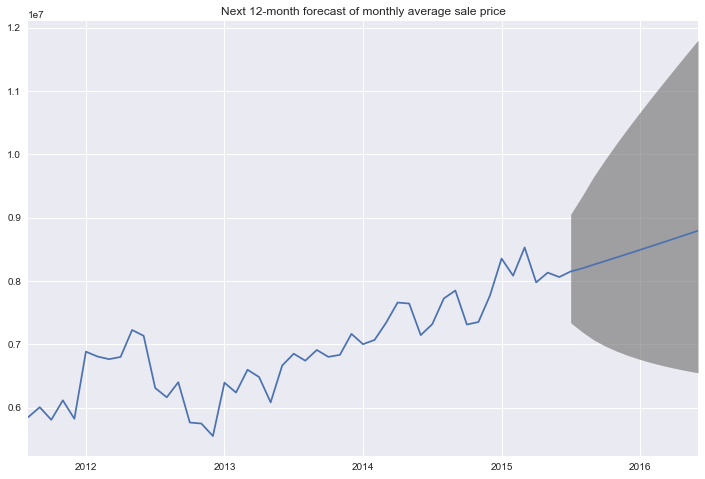

In [26]:
model = ARIMA(ts_log.values, order = (1,1,0))
results = model.fit()
pred, err95, ci95 = results.forecast(steps = 12)
future['mean_sale'] = np.exp(pred)

ts = pd.concat([ts, future])
fc_95 = pd.DataFrame(np.column_stack([np.exp(pred), np.exp(ci95)]), 
                     index=date_list, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])

ts['mean_sale'].plot(figsize = (12,8))
plt.title('Next 12-month forecast of monthly average sale price')
plt.fill_between(fc_95.index, fc_95.lower_ci_95, fc_95.upper_ci_95, color='gray', alpha=0.7)


# 3. Analysis of Russia's housing market based on number of transactions recorded and monthly average sale price of houses

From our dataset, we observe that for the most part, the monthly average sale price of houses illustrates a trend of increasing between 2011 and 2015. This could be attributed to either inflation or the Russian population having more money to purchase higher-priced houses. Interestingly, when we plot the number of transactions by month (we can ignore the month of August 2011 because only latter transactions for this month are recorded), we observe that there is a sharp dip in the number of transactions towards the end of 2014. This coincides with the timing of the escalation of the conflict in Crimea and Ukraine, which results in Russia being sanctioned by the US and EU. As a result, Russia's economy began to suffer a recession between the end of 2014 and early 2015. Hence, the sharp decrease in number of transactions along with a steady increase in the monthly average sale price implies that Russian housing market is most likely to have sufferred from an inflation. 

In [ ]:
s1 = train_set[['timestamp']]
s2 = pd.DataFrame({'no. trans': np.ones((train_set.shape[0]))})
tsh = pd.concat([s1,s2], axis = 1)
#Dates = pd.DatetimeIndex(train_set['timestamp'])
tsh = tsh.set_index(Dates).groupby(pd.TimeGrouper("M"))['no. trans'].agg('sum')
tsh = tsh.dropna()
tsh.plot()
plt.title('Number of transactions by month')
plt.show()

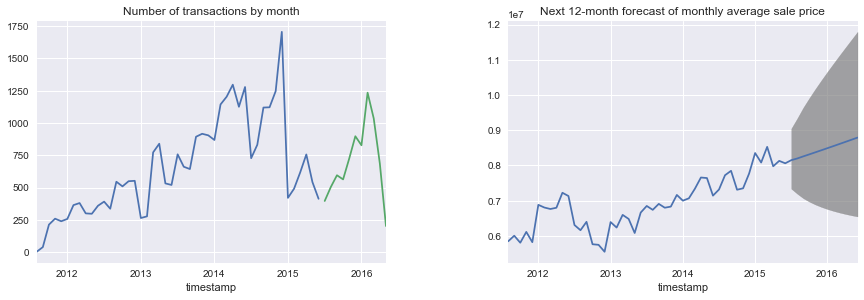

In [28]:
# Let's plot the number of transactions by month of the train set and test set together. 

s3 = test_set[['timestamp']]
s4 = pd.DataFrame({'no. trans': np.ones((test_set.shape[0]))})
tsh_te = pd.concat([s3,s4], axis = 1)
Dates_te = pd.DatetimeIndex(test_set['timestamp'])
tsh_te = tsh_te.set_index(Dates_te).groupby(pd.TimeGrouper("M"))['no. trans'].agg('sum')
tsh_te = tsh_te.dropna()

# We show a side-by-side view of this plot and our forecast of monthly average sale price
plt.subplot(1,2,1)
tsh.plot()
tsh_te.plot()
plt.title('Number of transactions by month')
plt.subplot(1,2,2)
ts['mean_sale'].plot()
plt.fill_between(fc_95.index, fc_95.lower_ci_95, fc_95.upper_ci_95, color='gray', alpha=0.7)
plt.xlabel('timestamp')
plt.title('Next 12-month forecast of monthly average sale price')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=2.0, hspace=0.25,
                    wspace=0.35)
plt.show()


The number of transactions by month eventually makes a recovery at the end of 2015 only to suffer another drop early 2016. In the meantime, the forecast for the monthly average sale price of houses for the next 12 months illustrates that the average house price will remain relatively high. Russia's economic crisis is not over yet. 

# 4. Train dataset

## 4.1 Shuffle and split up training data set

First, we shuffle and split training data into a train set and a test set

In [64]:
# We want to train 20% of the data 

# Apply standard scaler to data
scaler_tr = preprocessing.StandardScaler().fit(X_train)
X_train = scaler_tr.transform(X_train)
scaler_te = preprocessing.StandardScaler().fit(X_test)
X_test = scaler_te.transform(X_test)

# Then we shuffle
X_train_sh, y_train_sh = shuffle(X_train, y_train, random_state = 5)

num_test = 0.20
X_tr, X_te, y_tr, y_te = train_test_split(X_train_sh, y_train_sh, test_size=num_test, random_state=200)


## 4.2 Train via Scikit Learn XGBRegressor and use GridSearchCV to select parameter values

Next, we run GridSearchCV algorithm using a couple of different parameter combinations to find the best input combination before applying XGBoost Regression.

In [66]:
# Apply XGBRegressor and then use GridSearchCV to find the best combination of parameter values. 
xgbmodel = xgb.XGBRegressor()
xgb_params = {
    'max_depth': [2, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [50, 100, 300],
    'objective': ['reg:linear'],
    'silent': [1]
}

# Use r2 score compare parameter combinations
r2_scorer = make_scorer(r2_score)

# Run the grid search, using r2 score for comparison
grid_obj = GridSearchCV(xgbmodel, xgb_params, scoring=r2_scorer)
grid_obj = grid_obj.fit(X_tr, y_tr)

# Set the xgb regressor to the best combination of parameters
xgbmodel = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
xgbmodel.fit(X_tr, y_tr)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=0.7)

### 4.2.1 RMSE of our predictions on the remaining 20% of training data

We display the mean squared error values of our predictions obtained using XGBoost Regression with the parameter combination chosen by GridSearch CV.  

In [67]:
y_pred = xgbmodel.predict(X_te)
print(sqrt(mean_squared_error(y_te, y_pred)))

ids = test_set['id']
predictions = np.exp(xgbmodel.predict(X_test))-1

# Save predictions of test set into a csv file
output = pd.DataFrame({ 'id' : ids, 'price_doc': predictions })
output.to_csv('Russian-House-price-predictions1.csv', index = False)

0.47617926401566457


### 4.2.2 Cross validation results

[0]	train-rmse:14.3696	test-rmse:14.3697
[50]	train-rmse:1.1999	test-rmse:1.20747
[100]	train-rmse:0.433274	test-rmse:0.472734
[150]	train-rmse:0.404412	test-rmse:0.46174
[200]	train-rmse:0.3889	test-rmse:0.461053


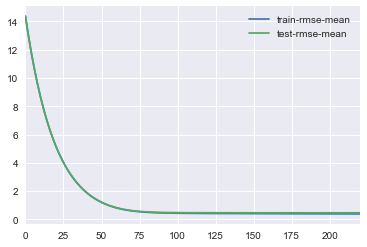

In [70]:
dtrain = xgb.DMatrix(X_tr, y_tr)

best_params = {'base_score':0.5, 
               'colsample_bylevel':1, 
               'colsample_bytree':0.7,
               'gamma':0,
               'learning_rate':0.05, 
               'max_delta_step':0, 
               'max_depth':5,
               'min_child_weight':1, 
               'missing':None, 
               'n_estimators':300, 
               'nthread':-1,
               'objective':'reg:linear', 
               'reg_alpha':0, 
               'reg_lambda':1,
               'scale_pos_weight':1, 
               'seed':0, 
               'silent':1, 
               'subsample':0.7}

cv_output = xgb.cv(best_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
                   verbose_eval=50, show_stdv=False)

cv_output[['train-rmse-mean','test-rmse-mean']].plot()

## 4.3 Train via XGBoost Learning API

This part is optional. We train our data using the XGBoost Learning API instead of the Scikit-learn wrapper interfact for XGBoost in the previous subsection

In [74]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X_tr, y_tr)
dtest = xgb.DMatrix(X_te)

model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=486)

### 4.3.1 RMSE of our predictions on the remaining 20% of training data

In [75]:
y_pred = model.predict(dtest)
print(sqrt(mean_squared_error(y_te, y_pred)))

ids = test_set['id']
dtest = xgb.DMatrix(X_test)
predictions = np.exp(model.predict(dtest))-1

output = pd.DataFrame({ 'id' : ids, 'price_doc': predictions })
output.to_csv('Russian-House-price-predictions2.csv', index = False)

0.47698348678573665
